In [1]:
import numpy as np
from numpy import ndarray
# Process the data
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
data: pd.DataFrame = pd.read_table("german.data-numeric",
                                   header=None, delim_whitespace=True)

num_cols = data.shape[1]

# Separate features from labels

X_df = data[list(range(num_cols-1))].astype(float)
y_df = data[num_cols-1] - 1  # 0 and 1 instead of 1 and 2
y_df = 2 * y_df - 1

X_df.columns += 1
X_df = (X_df - X_df.mean()) / X_df.std()

X_df.insert(0, 0, 1.)

In [3]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-1.253938,-1.235859,1.343342,-0.733065,1.832252,1.337409,0.449102,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
1,1.0,-0.458797,2.247070,-0.503176,0.965893,-0.699357,-0.317800,-0.963168,-0.765594,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
2,1.0,1.131486,-0.738298,1.343342,-0.414510,-0.699357,0.509805,0.449102,0.140434,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
3,1.0,-1.253938,1.749509,-0.503176,1.638398,-0.699357,0.509805,0.449102,1.046463,-0.340885,...,-0.195916,-0.552429,-0.338692,-3.121368,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
4,1.0,-1.253938,0.256825,0.420083,0.576549,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,1.808378,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.131486,-0.738298,-0.503176,-0.556090,-0.699357,0.509805,-0.963168,1.046463,-1.293076,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,1.99900,-1.304224
996,1.0,-1.253938,0.754386,-0.503176,0.222599,-0.699357,-0.317800,-2.375438,1.046463,-0.340885,...,-0.195916,-0.552429,2.949581,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,-1.304224
997,1.0,1.131486,-0.738298,-0.503176,-0.874645,-0.699357,1.337409,0.449102,1.046463,0.611307,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,0.634131,-0.149908,-0.49975,0.765973
998,1.0,-1.253938,1.998289,-0.503176,-0.520695,-0.699357,-0.317800,0.449102,1.046463,1.563498,...,-0.195916,-0.552429,-0.338692,0.320052,-0.206664,-0.4667,-1.575384,-0.149908,-0.49975,0.765973


As demonstrated in the report, Gibbs sampling now boils down to the loop:
* sample $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu^t, \Sigma)$ where
$$
    W = \Sigma^{-1} = \frac1\tau I_p + X^TX,
    \quad
    \mu^t = \Sigma X^Tz^t \in \mathbb R^p
$$
* sample $z^{t+1} \sim p(z|\beta^{t+1},y^t) = \exp(-\frac12\|z-X\beta\|^2) \prod_i \mathbf{1}_{\{y_iz_i > 0\}}$
* sample $y^{t+1} \sim p(y|z^{t+1}) = \mathrm{Ber}\left(\Phi(\beta_i^{t+1,T}x_i)\right)$

In [4]:
import scipy as sp
import scipy.linalg as splin
from scipy.stats import truncnorm, norm

In [95]:
def sample_truncated_gaussian(mean: ndarray, y, size=None):
    """
    Sample a vector of truncated Gaussians z with means
    mean[i] and in the support z[i]y[i] > 0.
    """
    dim = len(mean)
    a = -mean
    b = -mean
    a[y < 0] = -np.inf
    b[y > 0] = np.inf
    if size is not None:
        size = (size, dim)
    z = truncnorm.rvs(a, b, loc=mean, size=size)
    return z

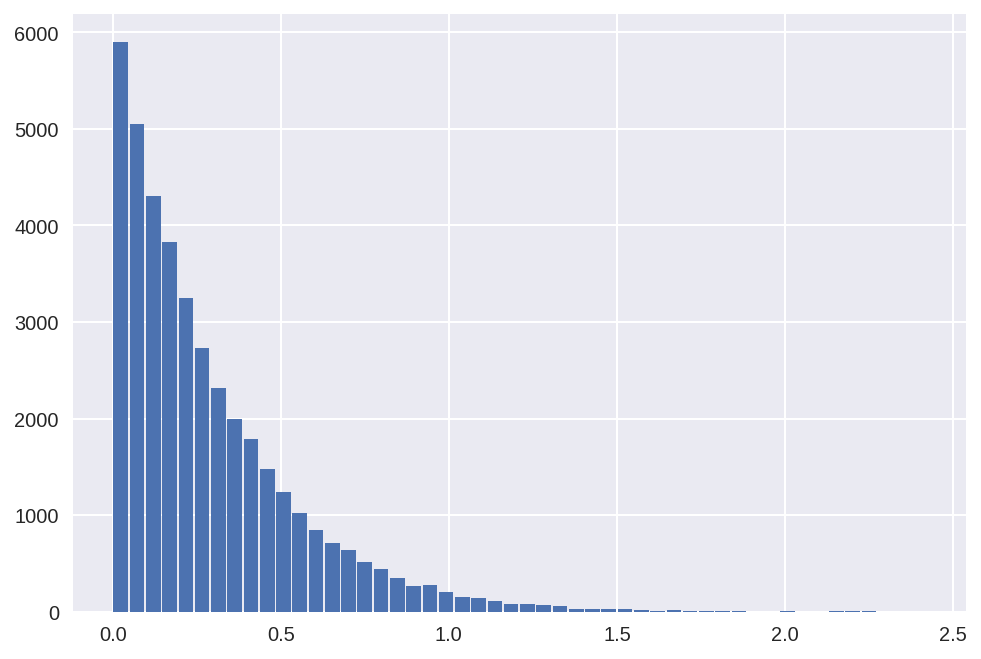

In [99]:
mean_ = np.array([-3.])
z_ = sample_truncated_gaussian(
    mean_, y=np.array([1]), size=40000)
z_.shape

plt.hist(z_[:, 0], bins=50, rwidth=.9);

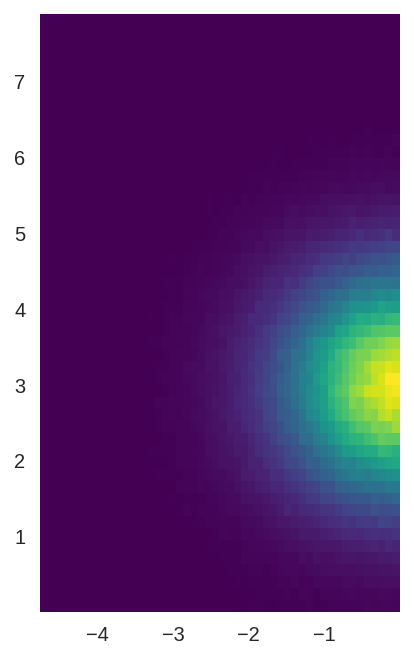

In [100]:
z_ = sample_truncated_gaussian(
    np.array([0., 3.]), y=np.array([-1, 1]), size=600000)
z_.shape

plt.hist2d(*z_.T, bins=50, cmap=plt.cm.viridis);
plt.axis('scaled');

In [147]:
def gibbs_sampler(X: ndarray, y: ndarray, tau=100, num_its=8000, burn_in=4000):
    """
    Gibbs sampler for the graphical model.
    """
    n = X.shape[0]
    d = X.shape[1]
    
    # posterior beta|z precision matrix
    prec_ = np.eye(d) / tau + X.T @ X  # shape (d, d)
    cov_ = splin.pinvh(prec_)  # covariance matrix
    print("Cov matrix:", cov_.shape)
    
    mu = np.zeros((d,))
    mu_s = np.zeros((num_its-burn_in, d))
    
    beta = np.random.randn(d) * tau ** .5
    betas = np.zeros((num_its-burn_in, d))
    
    z = np.random.randn(n)
    z_s = np.zeros((num_its-burn_in, n))
    
    # y = np.sign(z)
    # y_s = np.zeros((num_its-burn_in, n))
    
    for t in range(num_its):
        ## Sample beta|z
        beta = np.random.multivariate_normal(mu, cov=cov_)
        
        ## Sample z|beta,y
        postmean = X @ beta
        z = sample_truncated_gaussian(mean=postmean, y=y)  # shape (n,)
        mu = cov_ @ (X.T @ z)  # shape (d,)
        
        ## Sample y|z
        # y = np.sign(z)
        
        if t >= burn_in:
            mu_s[t-burn_in, :] = mu
            betas[t-burn_in, :] = beta
            z_s[t-burn_in, :] = z
            # y_s[t-burn_in, :] = y
    # return the full chains
    return betas, z_s, mu_s

In [159]:
betas, z_s, mu_s = gibbs_sampler(X_df.values, y_df.values,
    tau=1, num_its=10000, burn_in=0)

Cov matrix: (25, 25)


## Trace plots

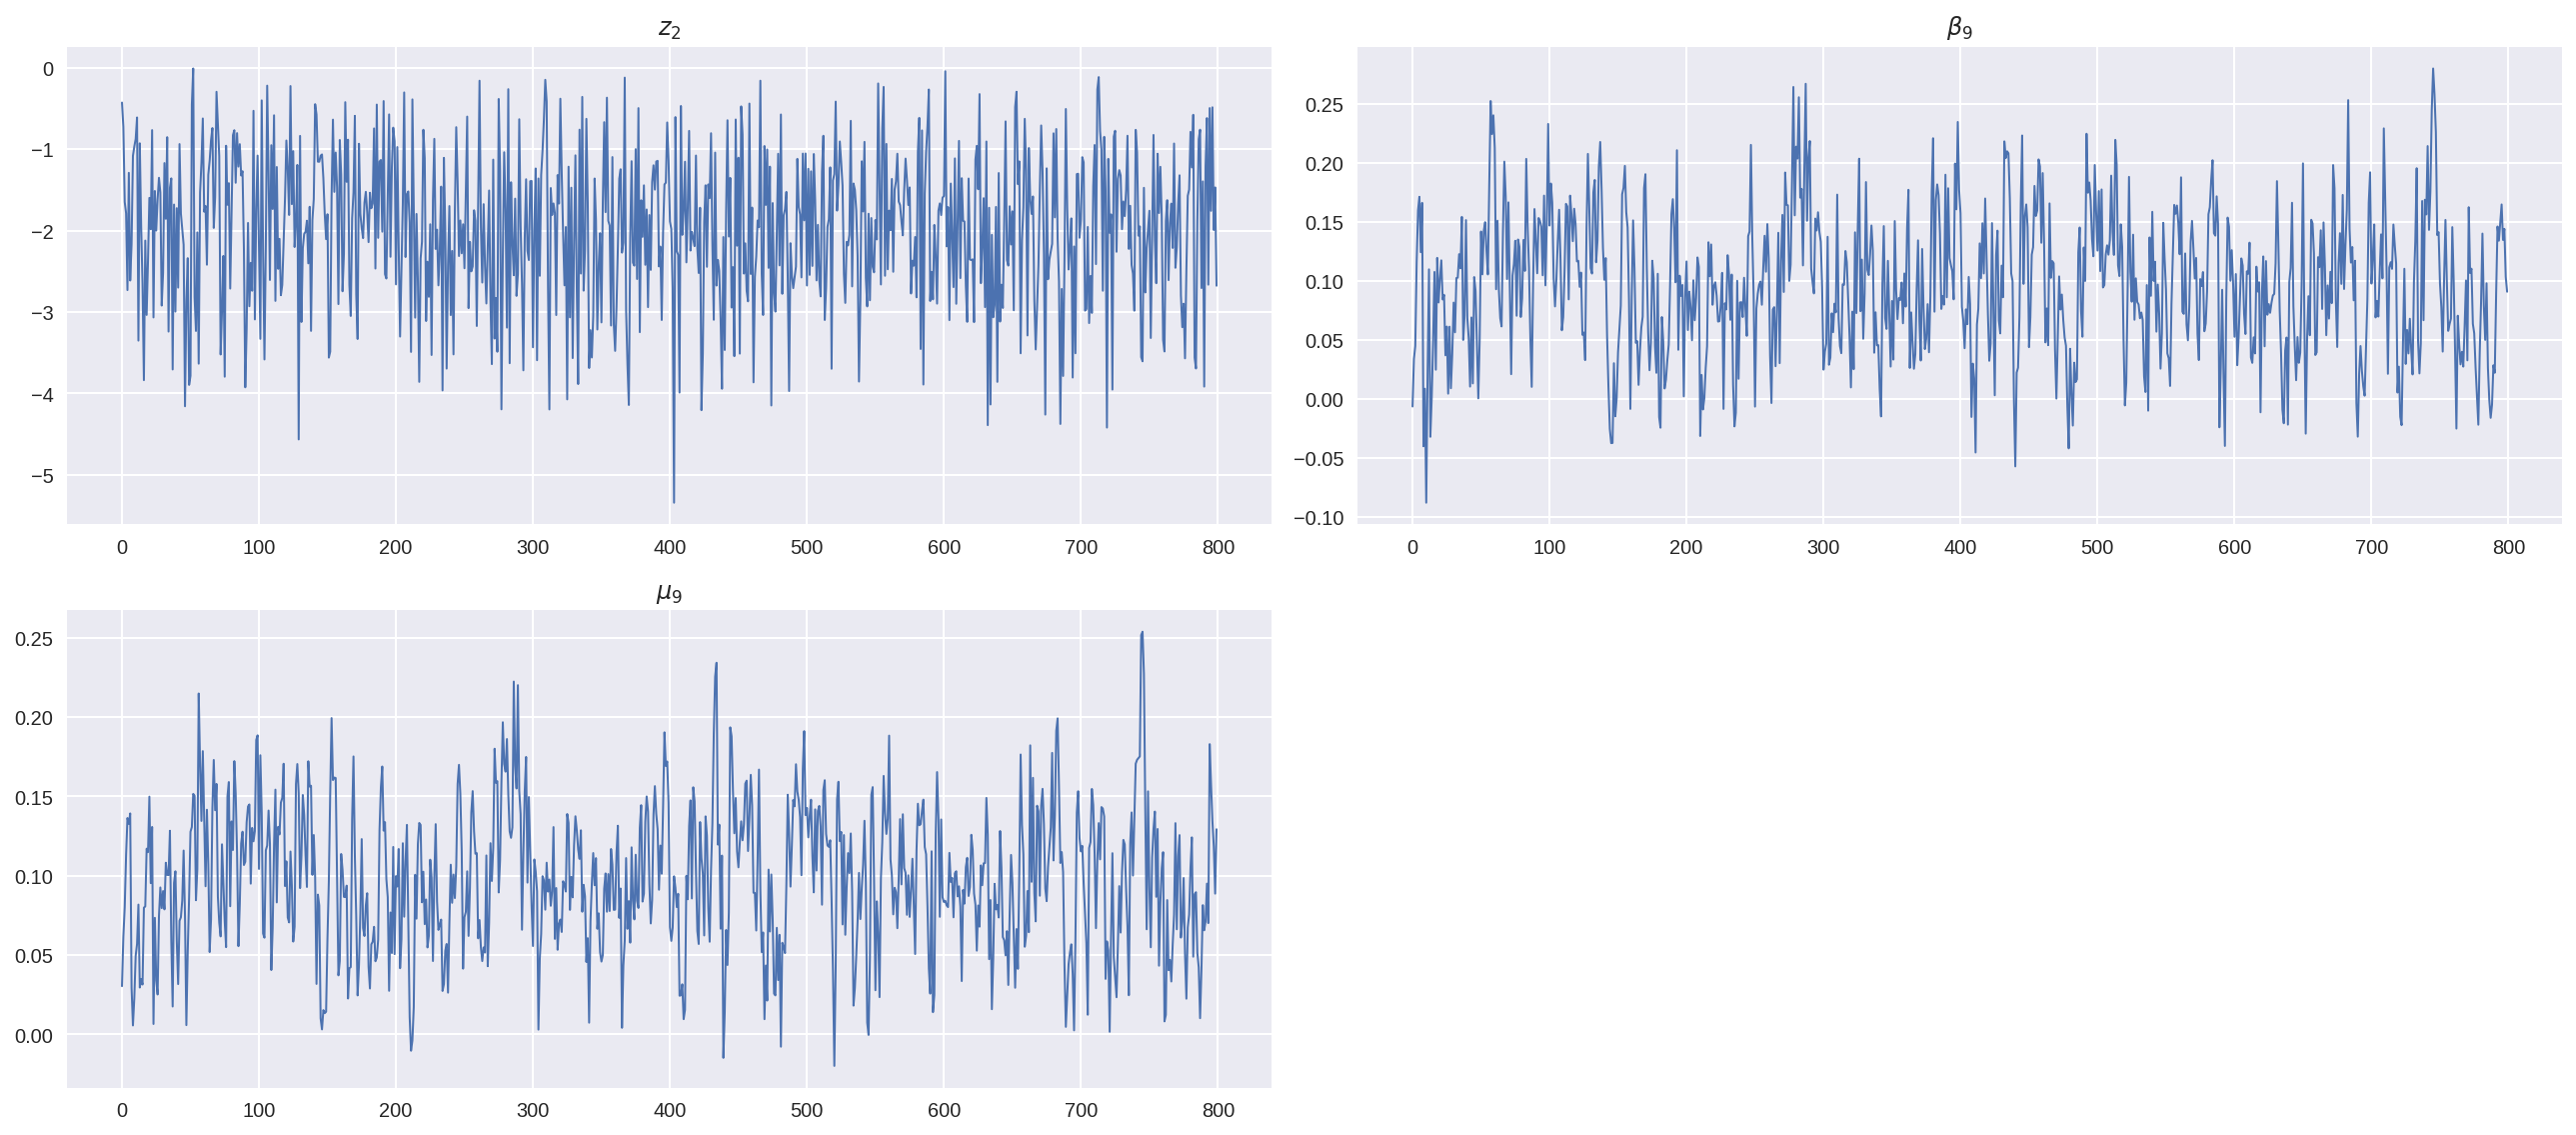

In [164]:
fig = plt.figure(figsize=(18, 8))

nrows = 2
ncols = 2

plot_ops = dict(lw=1.0)

t_max = 800

i = 2
plt.subplot(nrows,ncols,1)
plt.title("$z_{%d}$" % i)
plt.plot(np.arange(t_max), z_s[:t_max, i], **plot_ops)

plt.subplot(nrows,ncols,2)
plt.title("$\\beta_9$")
plt.plot(np.arange(t_max), betas[:t_max, 9], **plot_ops);

plt.subplot(nrows,ncols,3)
plt.title("$\\mu_9$")
plt.plot(np.arange(t_max), mu_s[:t_max, 9], **plot_ops);

fig.tight_layout()

In [176]:
burn_in = 1000

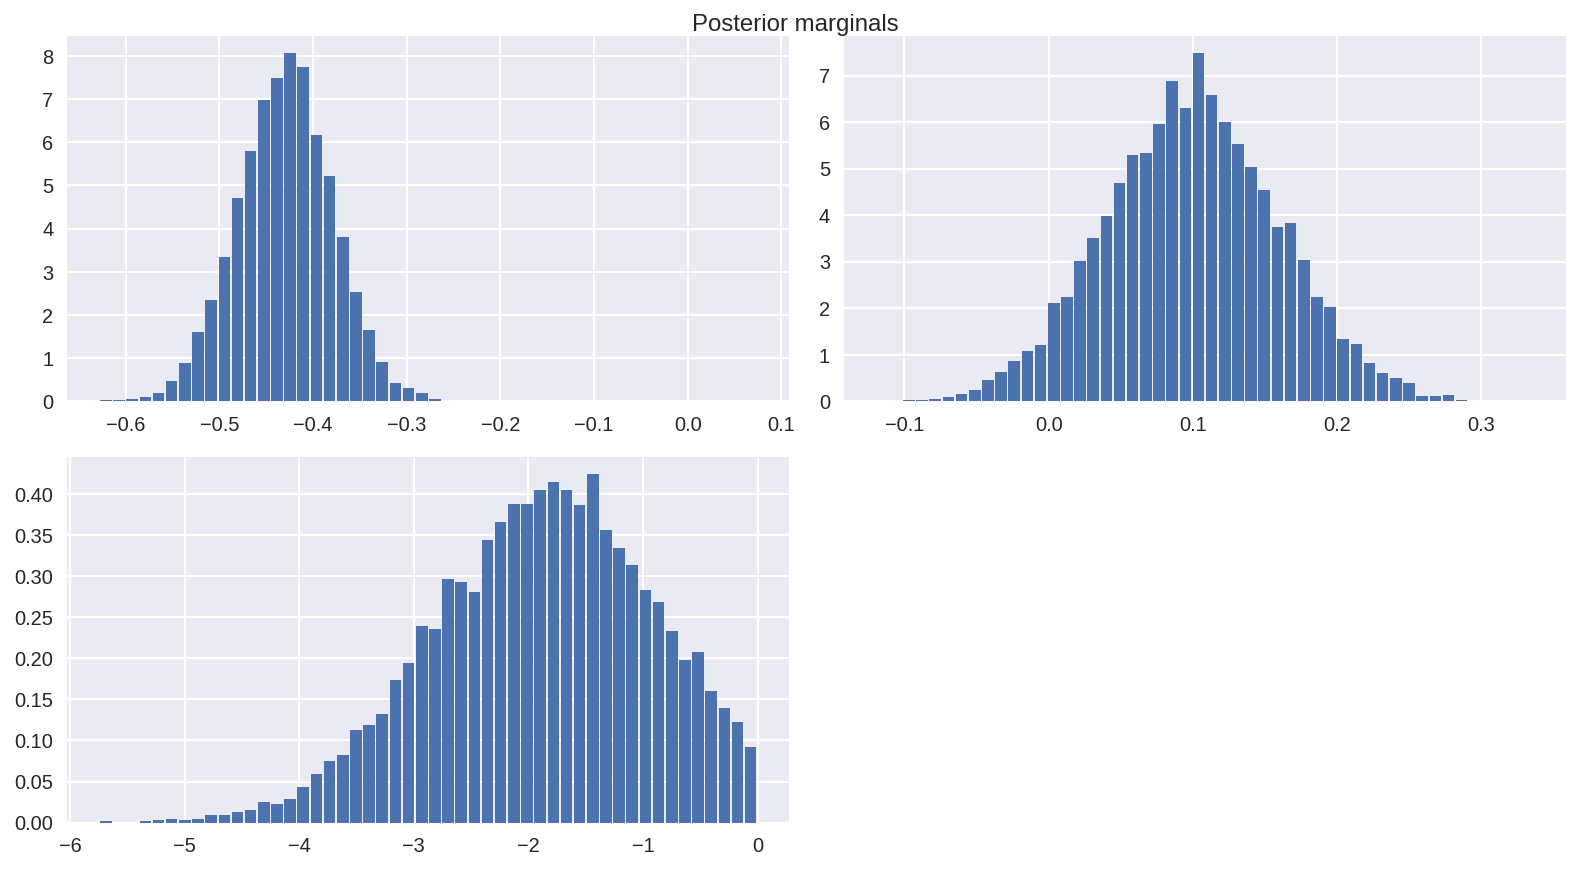

In [189]:
fig = plt.figure(figsize=(11, 6))

nrows = 2
ncols = 2

n_bins = 50

hist_opts = dict(rwidth=.88, density=True)

plt.subplot(nrows,ncols,1)
plt.hist(betas[:-burn_in, 1], bins=n_bins, **hist_opts);

plt.subplot(nrows,ncols,2)
plt.hist(betas[:-burn_in, 9], bins=n_bins, **hist_opts);

plt.subplot(nrows,ncols,3)
plt.hist(z_s[:-burn_in, 0], bins=n_bins, **hist_opts);

fig.tight_layout()
fig.suptitle("Posterior marginals", y=1.);


## Prediction

We do $y = \mathrm{sgn}(z)$ with $z$ sampled a posteriori.

In [141]:
y_predict = np.sign(z_s[-1])

In [142]:
np.sum(y_df.values == y_predict)

1000